# Lab 4 Retirement Planning Exercise Revisit

In this lab, we will redo the retirement planning exercise in Python. You can compare what we have here with the excel. As usual, we import all the packages needed in advance.

In [25]:
import scipy
import scipy.stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy

import pandas_datareader as pdr # use in step 1
import datetime # use in step 1
import pandas as pd # use in step 1 

## Step 1 Obtaining data

Similar to the lecture, we need to obtain the historical price data. 
There are many ways to obtain the price. For example, you can download the data online from websites like yahoo or from platforms such as Reuters or Bloomberg and then import them in python. Here, we introduce another way which utilizes existing packages in python to get the data directly. <br>

Let's first get the data of US Treasury. Recall the TICKER is 'VFISX', standing for Vanguard Short-Term Treasury Fund Investor Shares. We utilize pandas_datareader package to download the data for us. To achieve that, we need to input the following

(1) ticker, which is 'VFISX' here. <br>
(2) the starting time of the historical price we want to retrieve, here is Jan 1st, 2000.<br>
(3) the end time, here is Jan 2nd, 2020.<br>
(4) the frequency of the data, 'd' for daily, 'w' for weekly, 'm' for monthly. Similar to the exercise, we use monthly data here.<br>

For (2) and (3), we use datetime package to specify the time we want. <br>

For your reference, the output is of pandas dataframe type. So you can utilize the attributes of pandas dataframe class. 

In [26]:
data_VFISX=pdr.get_data_yahoo('VFISX',start=datetime.datetime(2000,1,1),end=datetime.datetime(2020,1,2),interval='m')
data_VFISX

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-01,10.00,9.94,9.99,9.94,0.0,5.721412
2000-02-01,9.98,9.93,9.95,9.97,0.0,5.766501
2000-03-01,9.99,9.96,9.97,9.99,0.0,5.804269
2000-04-01,10.03,9.96,10.00,9.96,0.0,5.815948
2000-05-01,9.96,9.90,9.96,9.94,0.0,5.832936
...,...,...,...,...,...,...
2019-09-01,10.65,10.56,10.64,10.60,0.0,10.536087
2019-10-01,10.65,10.58,10.61,10.61,0.0,10.562966
2019-11-01,10.61,10.57,10.61,10.59,0.0,10.560008


The loc attribute is used to access a group of rows and columns by label(s) or a boolean array in the given object.
We utilize it to extract the adjusted closing price.

In [30]:
adjClose_VFISX=data_VFISX.loc[: , "Adj Close"]

pct_change attribute can output percentage change between the current item and a prior element. The input is the shift to form the percentage change. By default, the shift is 1, which is desired for us, as we want to compute the monthly percentage change. If we use 12, then we are comparing the monthly return between different years (eg. Jan 2020 vs Jan 2019).

In [31]:
pct_change_VFISX=adjClose_VFISX.pct_change()

We remove the first NaN term to obtain the return of US Treasury

In [32]:
return_VFISX=pct_change_VFISX[1:]
return_VFISX

Date
2000-02-01    0.007881
2000-03-01    0.006549
2000-04-01    0.002012
2000-05-01    0.002921
2000-06-01    0.013149
                ...   
2019-09-01   -0.002069
2019-10-01    0.002551
2019-11-01   -0.000280
2019-12-01    0.001420
2020-01-01    0.001418
Name: Adj Close, Length: 240, dtype: float64

In [19]:
##Now let's try getting the data of S&P 500. Recall the TICKER is 'VFINX'. 

In [33]:
# fill in the missing part and uncomment the next line.
# data_VFINX=pdr.get_data_yahoo(,start=,end=,interval=)
data_VFINX=pdr.get_data_yahoo('VFINX',start=datetime.datetime(2000,1,1),end=datetime.datetime(2020,1,2),interval='m')

In [34]:
# what price of S&P 500 shall we use ? How do we get that from the data obtained
# adjClose_VFINX=data_VFINX.loc[]
adjClose_VFINX=data_VFINX.loc[:,'Adj Close']

In [35]:
# How do we get return of S&P 500 from the price
# pct_change_VFISX=adjClose.
# return_VFINX=pct_change_VFINX
pct_change_VFINX=adjClose_VFINX.pct_change(1)
return_VFINX=pct_change_VFINX[1:]

## Step 2 Find the distribution of returns <br>
 Disclaimer: This part is adapted from and edited based on the following online article (http://www.insightsbot.com/blog/WEjdW/fitting-probability-distributions-with-python-part-1)

From the historical data, we want to find the return distribution of US Treasury bond and S&P 500. In fact, we never know what the true distribution is, but we can find a good approximation of that. To determine how good of a fit this distribution is, we will use the Kolmogorov-Smirnov test for goodness of fit. This is a nonparametric test to compare a sample with a reference probability distribution. Our sample in this case is our return_VFINX variable, and the distribution to fit is our reference. This test is implemented in SciPy. We determine whether the reference distribution is a good fit or not using the P-Value returned by this test. The P-Value is defined as the fraction of synthetic sample distributions that has a larger K-S distance to the reference distribution than the historical data. A smaller p-value is interpreted as a poorer fit by the reference distribution.

We then store the distribution name and its p-value to the dist_results variable. Once we have completed this process for all our defined distributions, we will choose the distribution with the highest P-Value as the best fit. 
Note that this K-S test may be sensitive to the difference between the two distributions in spread, shape or median. There are other goodness of fit tests that you could also use each with its pros and cons.

In [47]:
def Fit_Distribution(index, distribution_list=['norm','lognorm','expon','logistic'], plot_CDF=True,plot_PDF=True):
    
    if index=='VFISX':
        data_for_fit=return_VFISX
    else :
        data_for_fit=return_VFINX
        
    param_record={} 
    dist_result=[]
    for dist_name in distribution_list:
        dist = getattr(scipy.stats, dist_name)    # get attributes for the reference distribution
        param=dist.fit(data_for_fit)              # fit the distribution for the data we specify
        param_record[dist_name] = param           # store he parameter
        # apply the  Kolmogorov-Smirnov test
        D_dist, p_dist = scipy.stats.kstest(data_for_fit, dist_name, args=param);
        dist_result.append((dist_name,p_dist))
    
    
    if plot_CDF==True: # plot CDF
        plt.figure(figsize=(12.8,9.6))
       # creating the histogram (cumulative form) of the original data
        h = plt.hist(data_for_fit, bins=50, density=True, cumulative=True, label='Empirical')
       # generating the distribution (cumulative form) of the reference distribution
        x = scipy.linspace(min(data_for_fit), max(data_for_fit), num=2000)
        for dist_name in distribution_list:
            dist = getattr(scipy.stats, dist_name)
            param = param_record[dist_name]
            cdf_fitted = dist.cdf(x, *param)
            plt.plot(x,cdf_fitted, label=dist_name)
        plt.xlim(min(data_for_fit),max(data_for_fit))
        plt.legend(loc='upper left')
        savefile_name='cdf_{asset}_fit.pdf'.format(asset=index) # save figure as pdf file
        plt.savefig(savefile_name,dpi=400)
        plt.show() 
         
               
    if plot_PDF==True: # plot Pdf
        plt.figure(figsize=(12.8,9.6))
        h = plt.hist(data_for_fit, bins=50, density=True, cumulative=False, label='Empirical')
       # generating the distribution (cumulative form) of the reference distribution
        x = scipy.linspace(min(data_for_fit), max(data_for_fit), num=2000)
        for dist_name in distribution_list:
            dist = getattr(scipy.stats, dist_name)
            param = param_record[dist_name]
            pdf_fitted = dist.pdf(x, *param)
            plt.plot(x,pdf_fitted, label=dist_name)
        plt.xlim(min(data_for_fit),max(data_for_fit))
        plt.legend(loc='upper left')
        savefile_name='pdf_{asset}_fit.pdf'.format(asset=index)  # save figure as pdf file
        plt.savefig(savefile_name)
        plt.show() 
        
     # select the best fit
    dist_best,dist_p_value = (max(dist_result,key=lambda item:item[1]))
        #store the name of the best fit and its p value
    return dist_best, dist_p_value

Let's apply this function on US Treasury Bond and see what will be a good distribution for that.

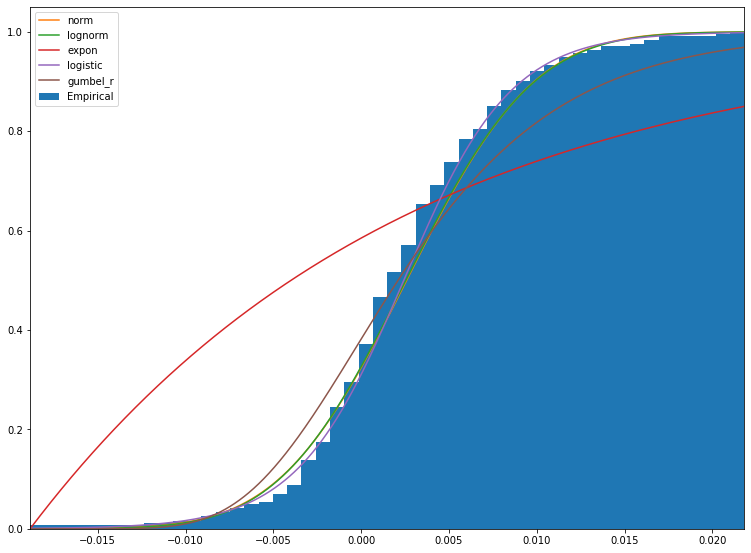

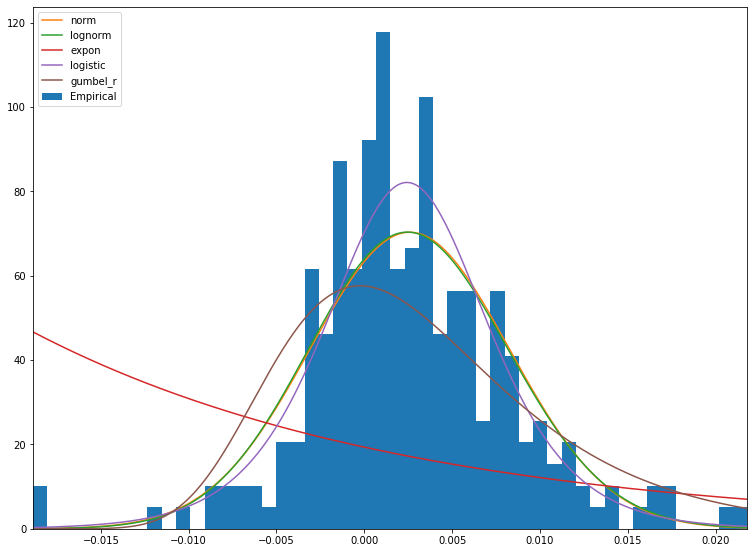

('logistic', 0.6451667586577975)

In [48]:
d_trial=['norm','lognorm','expon','logistic','gumbel_r']
Fit_Distribution('VFISX', distribution_list=d_trial,plot_CDF=True,plot_PDF=True)

From all distributions we consider, logistic is the best in terms of K-S test. Note the p-value here is 0.645.

## Step 3 Simulation of return

Here we provide the function that output simulated value at the time of retirement

In [50]:
Num_sim=5000 # number of trials
initial_value=2000 # the initial value we have for investment, which is 2000 dollars in the exercise
distribution='logistic' # the distribution of return, which we assume to be logistic here.
period=72 # number of months before retirement, here we set as 6 years to be consistent with the exercise
pct_VFINX=0.25 # percentage of money put in S&P 500, i.e. VFINX
goal=170000 # the value we want to achieve at the time of retirment

Recall we used rvs from  scipy.stats to simulate gaussian random variates in Lab 1. Without any input, rvs simulates standard normal random variates. If we want to simulate normal random variates with specific mean and variance, then we need to input these parameters in rvs. <br>

Different distributions may have different number of parameters. For instance, consider the following.

In [45]:
# if we fit US Treasury by normal distribution
param_VFISX=scipy.stats.norm.fit(return_VFISX)
param_VFISX

(0.0025847397652666877, 0.005674277056204011)

In [46]:
# if we fit US Treasury by lognormal distribution
param_VFISX=scipy.stats.lognorm.fit(return_VFISX)
param_VFISX

(0.014947046657360026, -0.37693154279081287, 0.37947223182793344)

In [49]:
# if we fit US Treasury by logistic distribution
param_VFISX=scipy.stats.logistic.fit(return_VFISX)
param_VFISX

(0.002425812345861802, 0.0030447603278036025)

One useful techniques is that we can use *param_VFISX instead of inputting the parameters one by one. This additional * allows us to pass a variable number of parameters. 

In [51]:
def return_simulate(Num_sim=5000,initial_value=2000,distribution='logistic',period=72,pct_VFINX=0.25,goal=170000,summary=True):
    
    value_put_in_VFINX=initial_value*pct_VFINX # how much we put in S&P 500
    value_put_in_VFISX=initial_value-value_put_in_VFINX # how much we put in US Treasury
    
    dist= getattr(scipy.stats, distribution)   # get attributes for the reference distribution
    param_VFISX=dist.fit(return_VFISX)         # fit the distribution for the return of US Treasury and store the parameter
    param_VFINX=dist.fit(return_VFINX)         # fit the distribution for the return of S&P500 and store the parameter
    
    Value_retire_vec=[] # record all simulated value at the time of retirement
    
    goal_count=0   # initialize the number of trials that achieve our goal
    for i in range(Num_sim):      
        #simulate return for US Treasury from now to the retirement time
        sim_return_VFISX=dist.rvs(*param_VFISX, size=period)  # we use *param since it allows us to pass a variable number
        # simulate return for S&P500 from now to the retirement time
        sim_return_VFINX=dist.rvs(*param_VFINX, size=period)  # we use *param since it allows us to pass a variable number
        
    # calculation of how much we have at the retirement time 
        current_value_VFISX=value_put_in_VFISX # how much we have in US Treasury at the first month
        current_value_VFINX=value_put_in_VFINX # how much we have in S&P 500 at the first month
        
        for j in range(period): # update the total value for each asset as time goes
            current_value_VFISX=(value_put_in_VFISX+current_value_VFISX)*(1+sim_return_VFISX[j]) # how much from US Treasury
            current_value_VFINX=(value_put_in_VFINX+current_value_VFINX)*(1+sim_return_VFINX[j]) # how much from S&P 500
           
        # add them into the total value at the time of retirement         
        eventual_value=current_value_VFISX+current_value_VFINX
        
        if eventual_value>=goal:
            goal_count=goal_count+1
        
        Value_retire_vec.append(eventual_value) # stores the total value at retirement for each trial
    
    prob_achieve_goal=goal_count/Num_sim                
    
    # compute some summary statistics and print them
    mean_value_at_retire=numpy.mean(Value_retire_vec)
    std_value_at_retire=numpy.std(Value_retire_vec)
    sem_value_at_retire=scipy.stats.sem(Value_retire_vec)
    
    # output summary
    if summary==True:
        print('With', initial_value,'dollar to invest each month,',
        'if',pct_VFINX*100, '% is put in S&P 500, we have the following,')
        print('The mean of total value at the time of retirement is', mean_value_at_retire,';')
        print('The standard deviation of total value at the time of retirement is', std_value_at_retire,';')
        print('The mean standard error of total value at the time of retirement is', sem_value_at_retire,';')
        print('The probability of achieveing the goal of',goal, 'is', prob_achieve_goal,'. \n')   
        
    return Value_retire_vec, prob_achieve_goal 

Now Let's simulate once with the above input.

In [52]:
numpy.random.seed(100)
sim_return_retire,prob_achieve_goal_retire=return_simulate(Num_sim,initial_value,distribution,period,pct_VFINX,goal,True)

With 2000 dollar to invest each month, if 25.0 % is put in S&P 500, we have the following,
The mean of total value at the time of retirement is 169611.1280581087 ;
The standard deviation of total value at the time of retirement is 11498.1248968038 ;
The mean standard error of total value at the time of retirement is 162.6243049528949 ;
The probability of achieveing the goal of 170000 is 0.4506 . 



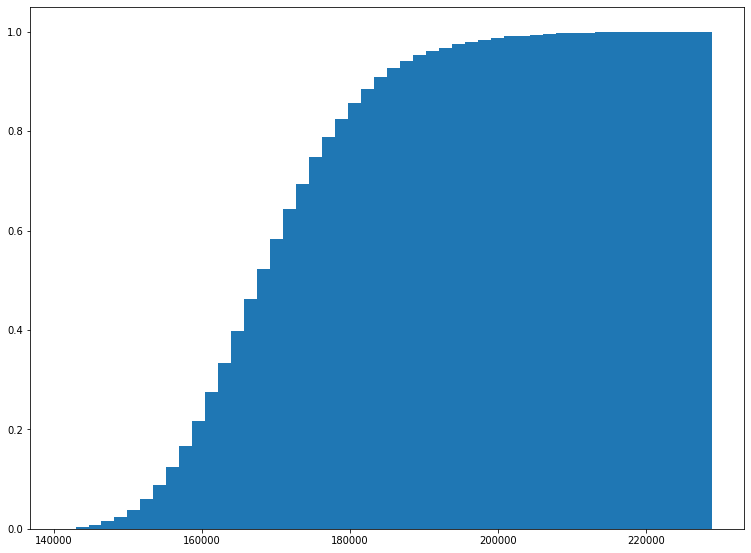

In [53]:
plt.figure(figsize=(12.8,9.6))
plt.hist(sim_return_retire,range=(min(sim_return_retire),max(sim_return_retire)), bins=50,density=True, cumulative=True);

## Wrapping up: Retirement Planning Analysis

The function below helps you analyze the retirment planning exercise with varying percentage of money put in the US Treasury. To be consistent with the exercise, we consider the following input. For percentage putting in US Treasury, we consider 25% and 75% for now.

In [54]:
Num_sim=5000 # number of trials
initial_value=2000 # the initial value we have for investment, which is 2000 dollars in the exercise
distribution='logistic' # the distribution of return, which we assume log-normal here.
period=72 # number of months before retirement, here we set as 6 years to be consistent with the exercise
pct_VFINX_vec=[0.25,0.75] # the percentages put in US Treasury that we want to analyze
goal=170000  # the value we want to achieve at the time of retirment

We now wrap up everything in the following function.

In [55]:
def retirement_planning(Num_sim=5000,initial_value=2000,distribution='logistic',period=72,pct_VFINX_vec=[0.25,0.75],goal=170000):
    
    N=len(pct_VFINX_vec)   # how many different percentage we want to try
    Value_retire_Mat=[]   # store the values at the time of retirement for all the proprotion put in US Treasury
    prob_of_achieve_vec=[]  # store the probability to achieve the goal for each percentage put in US Treasury
    for pct_VFINX in pct_VFINX_vec: # use the previous function for each percentage in interest
        eventual_value, prob_of_achieve=return_simulate(Num_sim,initial_value,distribution,period,pct_VFINX,goal,True)
        Value_retire_Mat.append(eventual_value)
        prob_of_achieve_vec.append(prob_of_achieve)
    plt.figure()
    colors_vec = cm.rainbow(numpy.linspace(0, 1, N))  # use different color for indication
        
    # plot. here we introduce another way to obtain a nice cdf plot
    fig=plt.figure(figsize=(12.8,9.6))
    for i in range(N):
        counts, bin_edges = numpy.histogram(Value_retire_Mat[i], bins=50, density=False)
        counts=counts.astype(float)/Num_sim
        cdf = numpy.cumsum(counts)
        plt.plot(bin_edges[0:-1], cdf,linestyle='--', color=colors_vec[i],label=str(pct_VFINX_vec[i]))
        plt.ylim((0,1))
        plt.grid(True)

    #  plt.hist(Value_retire_Mat[i], range=(min(Value_retire_Mat[i]),max(Value_retire_Mat[i])), bins=100,density=True, 
      #           histtype='step', cumulative=True, label=str(pct_VFINX_vec[i]),color=colors_vec[i])       
    plt.title('CDF of value at retirement over N=%i trials' %Num_sim)
    plt.legend(loc=2)   
   
    savefile_name='CDF_retirement_analysis_fit_by_{dist}.pdf'.format(dist=distribution)
    plt.savefig(savefile_name)    
    
    return prob_of_achieve_vec

With 2000 dollar to invest each month, if 25.0 % is put in S&P 500, we have the following,
The mean of total value at the time of retirement is 166662.50394222717 ;
The standard deviation of total value at the time of retirement is 10849.573648942587 ;
The mean standard error of total value at the time of retirement is 153.45148791912965 ;
The probability of achieveing the goal of 170000 is 0.3478 . 

With 2000 dollar to invest each month, if 75.0 % is put in S&P 500, we have the following,
The mean of total value at the time of retirement is 179376.83365620137 ;
The standard deviation of total value at the time of retirement is 31628.90873016589 ;
The mean standard error of total value at the time of retirement is 447.34505363492633 ;
The probability of achieveing the goal of 170000 is 0.5708 . 



<Figure size 432x288 with 0 Axes>

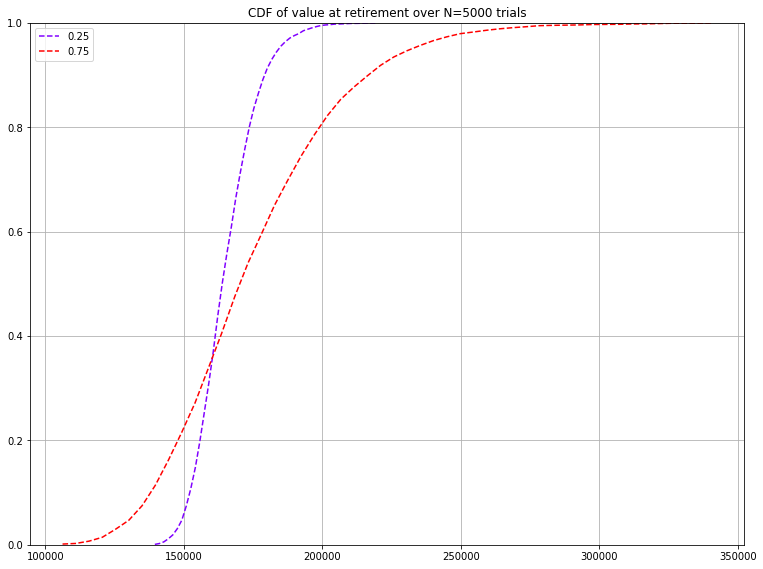

In [162]:
retire_short_analysis=retirement_planning(Num_sim,initial_value,distribution,period,pct_VFINX_vec,goal);

We now vary the proportion put in the US Treasury by specifying the percentage we want to try. 

With 2000 dollar to invest each month, if 0.0 % is put in S&P 500, we have the following,
The mean of total value at the time of retirement is 159946.222753872 ;
The standard deviation of total value at the time of retirement is 4532.214433747978 ;
The mean standard error of total value at the time of retirement is 64.10160167860279 ;
The probability of achieveing the goal of 170000 is 0.014 . 

With 2000 dollar to invest each month, if 25.0 % is put in S&P 500, we have the following,
The mean of total value at the time of retirement is 169900.93808525644 ;
The standard deviation of total value at the time of retirement is 11797.166878009532 ;
The mean standard error of total value at the time of retirement is 166.85382018096803 ;
The probability of achieveing the goal of 170000 is 0.4606 . 

With 2000 dollar to invest each month, if 50.0 % is put in S&P 500, we have the following,
The mean of total value at the time of retirement is 179579.91231826335 ;
The standard deviation of total

<Figure size 432x288 with 0 Axes>

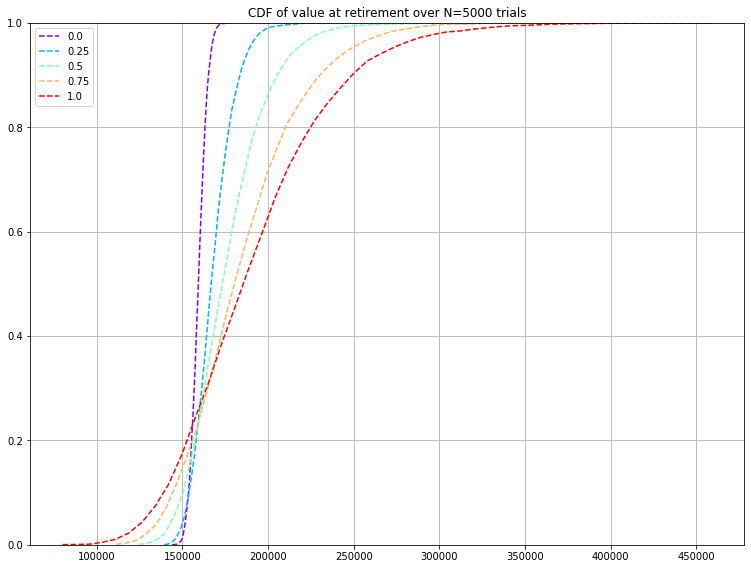

In [56]:
pct_trial=numpy.linspace(0,1,5) # we try all quantiles here.
retirment_analysis=retirement_planning(Num_sim,initial_value,distribution,period,pct_trial,goal)

From the CDF plot, it is clear that as we put lower money in US Treasury, the CDF has wider spread, indicating higher risk. 